In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import pandas as pd
from src import preprocess, knn_auto, get_hg_reduction, scatterplot
import igraph as ig
import anndata
import leidenalg as la
from sklearn.decomposition import PCA
from umap import UMAP

In [43]:
res = np.load('output/resolution_search.h5ad.npy', allow_pickle=True)

In [48]:
dd = res.item()

In [125]:
adata = anndata.read_h5ad('data/romanov_brain.h5ad')

In [126]:
adata = preprocess(
    adata,
    filter_genes=True,
    normalize=True,
    log1p=True,
    high_var=True,
    scale=True,
)

adata has shape (2881, 24341)


/Users/ehasanaj/miniconda3/envs/ml38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning:

Revieved a view of an AnnData. Making a copy.



After preprocessing, adata has shape (2881, 3729)


<h2>KNN</h2>

In [5]:
sources_base, targets_base, weights_base = knn_auto(adata.X, n_neighbors=5)
gg_base = ig.Graph(directed=False)
gg_base.add_vertices(adata.shape[0]) # cells
gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))

In [6]:
part_base = la.find_partition(
    gg_base,
    la.RBConfigurationVertexPartition,
    resolution_parameter=1,
)
predictions_base = np.array(part_base.membership, dtype=int)

In [ ]:
a = np.array((sns.color_palette("Set2").as_hex()))
gg_base.write_svg(
    '../poster/knn_graph100.svg',
    vertex_size=7,
    labels=None,
    edge_stroke_widths=[1] * len(sources_base),
    edge_colors=['#AAAAAA'] * len(sources_base),
    #colors=a[predictions_base].tolist(),
)

In [133]:
pca = PCA(40)
ump = UMAP(spread=0.2)
adata.obsm['x_emb'] = pca.fit_transform(adata.X)
adata.obsm['x_emb_2d'] = ump.fit_transform(adata.obsm['x_emb'])

/Users/ehasanaj/miniconda3/envs/ml38/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



In [134]:
fig_base = scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    labels=predictions_base.astype(str),
    return_fig=True,
)
fig_base.show()
fig_base.write_image('../poster/cluster_base2.svg', width=800, height=800)

<h2>HG</h2>

In [127]:
# this is sparse
reduced_adj = get_hg_reduction(adata.X, n_clusters=4)
print(f"Adjacency matrix has shape {reduced_adj.shape}")

100%|████████████████████████████████████████████████████████████████████████| 3729/3729 [04:26<00:00, 13.98it/s]


Adjacency matrix has shape (2881, 2881)


In [128]:
sources, targets = reduced_adj.nonzero()
weights = np.array(reduced_adj[sources, targets])
gg = ig.Graph(directed=False)
gg.add_vertices(adata.shape[0]) # cells
gg.add_edges(list(zip(list(sources), list(targets))))

In [122]:
a = np.array((sns.color_palette("Set2").as_hex()))
vv = np.square(weights.flat)
vv /= vv.max()
vv[vv<0.05] = 0
vv *= 2
gg.write_svg(
    '../poster/hg_graph100-leiden.svg',
    vertex_size=7,
    labels=None,
    #edge_stroke_widths=[1] * len(sources_base),
    edge_stroke_widths=vv.tolist(),
    edge_colors=['#AAAAAA'] * len(sources_base),
    colors=a[predictions_reduced_hg].tolist(),
)

In [130]:
part = la.find_partition(
    gg,
    la.RBConfigurationVertexPartition,
    weights=weights.flatten(),
    resolution_parameter=1,
)
predictions_reduced_hg = np.array(part.membership, dtype=int)

In [137]:
fig = scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    labels=predictions_reduced_hg.astype(str),
    return_fig=True,
)
fig.show()
fig.write_image('../poster/cluster_hg2.svg', width=800, height=800)

In [106]:
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from tqdm import tqdm

X = adata.X
n_clusters=4
n_samples, n_features = X.shape

# Initialize
# incidence matrix has a 1 in (i, j) if sample i is in hyperedge j
incidence_mat = np.zeros((n_samples, n_features))
# hyperedge_weight matrix contains a "weight" for every hyperedge.
hyperedge_weight_mat = np.zeros(n_features)
km = KMeans(n_clusters=n_clusters)

for feature in tqdm(range(n_features)):
    # Skip if there are less unique values than n_clusters
    if np.unique(X[:, feature]).size < n_clusters:
        continue
    # Find clusters for the given gene
    labels = km.fit_predict(X[:, feature].reshape(-1, 1))
    # If only 1 cluster was found, skip this gene.
    if len(km.cluster_centers_) == 1:
        continue
    # Next, we need to find which cluster has the highest mean.
    # The means here coincide with the cluster centers since
    # the samples are 1D.
    best_label = np.argmax(km.cluster_centers_.flatten())
    argidx = np.argwhere(labels==best_label).flatten()
    # Skip this gene if the top cluster contains <= 3 points, since
    # these are probably outliers.
    if argidx.size <= 3:
        continue
    # Points in the cluster with ID best_label will be assigned to
    # a hyperedge
    incidence_mat[argidx, feature] = 1
    # We assign a weight to this hyperedge based on log fold change,
    # i.e., the log ratio between the expression of this gene in the
    # top cluster vs the rest.
    hyperedge_weight_mat[feature] = (
        np.max(km.cluster_centers_) # same as X[labels==best_label, feature].mean()
        - X[labels!=best_label, feature].mean()
    )

100%|████████████████████████████████████████████████████████████████████████| 2436/2436 [00:52<00:00, 46.28it/s]


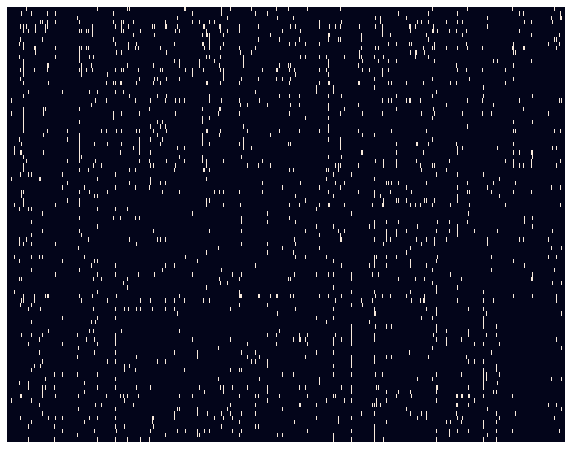

In [112]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
sns.heatmap(incidence_mat, ax=ax, cbar=False)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

In [40]:
fig.write_image('../poster/cluster_hg.svg', width=800, height=800)

In [138]:
fig = scatterplot(
    x=adata.obsm['x_emb_2d'][:, 0],
    y=adata.obsm['x_emb_2d'][:, 1],
    labels=adata.obs['annotations'].astype(str),
    return_fig=True,
)
fig.show()
fig.write_image('../poster/cluster_real.svg', width=800, height=800)

In [55]:
a = np.random.randint(0, 100, (1, 50))
a = np.sort(a)

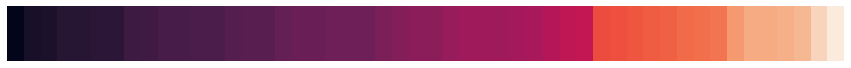

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 1))
sns.heatmap(
    a,
    ax=ax,
    cbar=False,
)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('../poster/gene.svg', dpi=300)

In [79]:
x, y = np.meshgrid(np.linspace(0, 1, num=5), np.linspace(0, 1, num=5))

<AxesSubplot:>

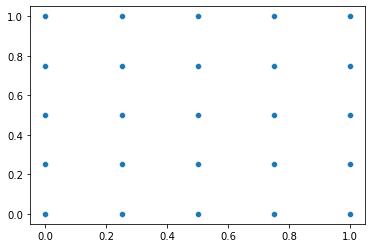

In [80]:
sns.scatterplot(x=x.flat, y=y.flat)